In [6]:
from init_nb import init_notebook
config = init_notebook()
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bold_dementia.utils.configuration import get_config
from bold_dementia.utils.saving import save_run
from bold_dementia.stats.univariate import make_fc_data, run_test, export_results, merge_configs
from bold_dementia.connectivity import reshape_pvalues, plot_matrix, Atlas


random.seed(config["seed"])

N = 100

In [7]:
maps_path = Path(
    "/bigdata/jlegrand/data/Memento/output/connectivity/atlas-GINNA_merged"
)
model_specs_path = Path(
    "/homes_unix/jlegrand/AD-prediction/LM_specs/OLS_cenanom.yml"
)
    
maps_specs = get_config(maps_path / "parameters.yml")
model_specs = get_config(model_specs_path)
print(model_specs)

df, edges, parameters = make_fc_data(maps_path, maps_specs, model_specs)


{'NAME': 'ols-cenanom', 'RHS_FORMULA': 'AD + scale(current_scan_age) + SEX + NIVETUD + scale(`total intracranial`) + CEN_ANOM', 'GROUPS': None}
   RSN02_RSN01  RSN03_RSN01  RSN03_RSN02  RSN04_RSN01  RSN04_RSN02  \
0     0.130525     0.217417    -0.190494     0.075858     0.156586   
1     0.140742    -0.057584    -0.031611    -0.355143    -0.286021   
2     0.174282     0.029205     0.185511     0.345416     0.137383   
3     0.005840    -0.174280     0.252891     0.328150     0.122189   
4     0.180687     0.035073     0.558452     0.196022    -0.002325   

   RSN04_RSN03  RSN05_RSN01  RSN05_RSN02  RSN05_RSN03  RSN05_RSN04  ...  \
0     0.113624     0.116368     0.023231    -0.096788    -0.216254  ...   
1    -0.098679     0.289175     0.427514    -0.006181    -0.197272  ...   
2    -0.166671     0.239852     0.229611     0.071937    -0.128278  ...   
3    -0.271702     0.200502     0.192088     0.116803    -0.158616  ...   
4    -0.078938     0.190870     0.298480     0.145692    -0.

In [8]:
from dask_jobqueue import SLURMCluster
from bold_dementia.stats.permutations import generate_null_dask
from dask.distributed import Client, progress

with SLURMCluster(
    cores=1,
    memory="1GB",
    walltime="00:05:00",
    log_directory="/homes_unix/jlegrand/poubs"
) as cluster:
    cluster.scale(10)
    client = Client(cluster)
    permuted_slopes, permutation_scheme = generate_null_dask(
        df, edges, parameters, client, N=50
    )

<Client: 'tcp://10.85.1.93:40739' processes=0 threads=0, memory=0 B>


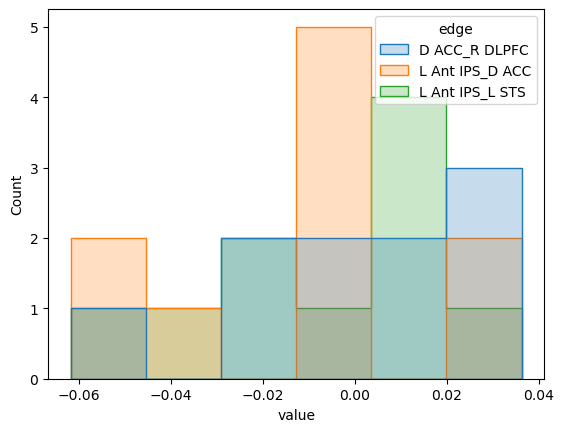

In [8]:

cols = random.sample(edges, k=3)
msk = permuted_slopes.edge.isin(cols)
m = permuted_slopes[msk].melt(id_vars="edge")
sns.histplot(m, x="value", hue="edge", element="step")
plt.show()

In [30]:
params = merge_configs(maps_specs, model_specs)
save_run(
    params,
    lambda obj, path: obj.to_csv(path),
    {"null_distribution_interactive.csv": permuted_slopes,},
    dirkey="statresults"
)


PosixPath('/homes_unix/jlegrand/data/Memento/output/statresults/atlas-msdl_merged_ols-cenanom')